# Detection results
This notebook presents detection evaluation results of two final models on different test sets

In [1]:
import os
import sys
import argparse
import traceback


import logging
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from itertools import combinations, permutations

import cmbnet.utils.utils_plotting as utils_plotting
import cmbnet.utils.utils_evaluation as utils_eval
import ast

In [2]:
eval_dir = "../../data-misc/evaluations"
l1_dirs = ['Scratch-Pretrained-FineTuned', 'TL-Pretrained-FineTuned']
l2_dirs = ['predict_cmb_valid', 'predict_cmb_dou', 'predict_cmb_crb']
l3_dirs = ['valloss', 'F1macro']


classification_fname = "classification_metrics.csv"
detection_metrics_fname = "detection_metrics.csv"
segmentation_metrics_fname = "segmentation_metrics.csv"

study_results_det_fname = "study_results_detection.pkl"
study_results_seg_fname = "study_results_segmentation.pkl"

cmb_results_det_fname = "all_cmbs_tracking.pkl"


df_classification, df_detection, df_segmentation, \
    detection_details, segmentation_details, cmb_results = \
        utils_eval.load_evaluation_data(eval_dir, l1_dirs, l2_dirs, l3_dirs)

In [3]:
gt_radiomics_metadata_csv = (
    "/storage/evo1/jorge/MicrobleedNet/data-misc/csv/CMB_radiomics_metadata.csv"
)
gt_cmb_metadata_csv = (
    "/storage/evo1/jorge/MicrobleedNet/data-misc/csv/CMB_metadata_all.csv"
)
all_studies_csv = "/storage/evo1/jorge/MicrobleedNet/data-misc/csv/ALL_studies.csv"

all_studies_df = pd.read_csv(all_studies_csv)
GT_metadata = pd.read_csv(gt_cmb_metadata_csv)
GT_metadata_radiomics = pd.read_csv(gt_radiomics_metadata_csv)

# Convert string representations of tuples to actual tuples
GT_metadata["CM"] = GT_metadata["CM"].apply(lambda x: tuple(ast.literal_eval(x)))
GT_metadata_radiomics["CM"] = GT_metadata_radiomics["CM"].apply(
    lambda x: tuple(ast.literal_eval(x))
)

GT_metadata_all = pd.merge(
    GT_metadata, GT_metadata_radiomics, on=["seriesUID", "CM"], how="inner"
).drop(
    columns=[
        "firstorder_10Percentile",
        "firstorder_90Percentile",
        "firstorder_Energy",
        "firstorder_Entropy",
        "firstorder_InterquartileRange",
        "firstorder_Kurtosis",
        "firstorder_Maximum",
        "firstorder_MeanAbsoluteDeviation",
        "firstorder_Mean",
        "firstorder_Median",
        "firstorder_Minimum",
        "firstorder_Range",
        "firstorder_RobustMeanAbsoluteDeviation",
        "firstorder_RootMeanSquared",
        "firstorder_Skewness",
        "firstorder_TotalEnergy",
        "firstorder_Uniformity",
        "firstorder_Variance",
    ]
)

/tmp/ipykernel_2256530/3961993545.py:10: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  GT_metadata = pd.read_csv(gt_cmb_metadata_csv)


## Detection results

In [4]:
# TODO: select which to show

dataset = ["dou", "crb", "valid"]
model = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
# criteria = ["F1macro", "valloss"]
criteria = ["valloss"]
typemetric = "Macro - "
df_tmp = df_detection.copy()

selected = df_tmp[(df_tmp['Dataset'].isin(dataset)) & (df_tmp['Model'].isin(model)) & (df_tmp['Criteria'].isin(criteria))]
selected = selected[selected['Metric'].str.contains(typemetric)]
table4results = selected[["Model",	"Dataset",	"Metric",	"Mean",	"Std."]]
table4results['Mean ± Std.'] = table4results['Mean'].round(2).astype(str) + ' ± ' + table4results['Std.'].round(2).astype(str)
table4results['Metric'] = table4results['Metric'].str.replace(typemetric, "")
table4results_final = table4results.pivot_table(
    index=['Model', 'Dataset'],
    columns='Metric',
    values='Mean ± Std.',
    aggfunc='first'  # Since there should be only one entry per group, 'first' is a safe choice here
).reset_index().sort_values(by=['Dataset'])
numeric_columns = ['Precision', 'Recall', 'F1', 'FPcmb', 'FPavg']
table4results_final


Metric,Model,Dataset,F1,FPavg,FPcmb,Precision,Recall
0,Scratch-Pretrained-FineTuned,crb,0.43 ± 0.19,0.89 ± 1.45,0.35 ± 0.95,0.78 ± 0.25,0.34 ± 0.32
3,TL-Pretrained-FineTuned,crb,0.49 ± 0.26,1.06 ± 2.01,0.38 ± 0.96,0.68 ± 0.38,0.29 ± 0.34
1,Scratch-Pretrained-FineTuned,dou,0.87 ± 0.19,0.5 ± 1.24,0.15 ± 0.46,0.91 ± 0.19,0.79 ± 0.34
4,TL-Pretrained-FineTuned,dou,0.81 ± 0.16,1.15 ± 1.87,0.4 ± 0.72,0.75 ± 0.28,0.7 ± 0.39
2,Scratch-Pretrained-FineTuned,valid,0.8 ± 0.2,1.7 ± 2.8,0.43 ± 0.75,0.5 ± 0.45,0.81 ± 0.3
5,TL-Pretrained-FineTuned,valid,0.74 ± 0.2,1.75 ± 2.77,0.53 ± 0.9,0.49 ± 0.44,0.76 ± 0.31


In [5]:
formatted_df = table4results_final.copy()

# Define the metrics and specify which ones are better when minimal
metrics = ['Precision', 'Recall', 'F1', 'FPcmb', 'FPavg']
minimize_metrics = ['FPcmb', 'FPavg']  # Metrics where lower is better

# Loop through each dataset and metric, find the best value and apply bold
for dataset in formatted_df['Dataset'].unique():
    for metric in metrics:
        # Filter the DataFrame for the current dataset and metric
        subset = formatted_df[(formatted_df['Dataset'] == dataset)]
        
        # Determine the best value depending on whether higher is better
        if metric in minimize_metrics:
            best_value = subset[metric].min()  # Lower is better for these metrics
        else:
            best_value = subset[metric].max()  # Higher is better for these metrics
        
        # Apply bold to the best value
        formatted_df.loc[(formatted_df['Dataset'] == dataset) & (formatted_df[metric] == best_value), metric] = '\\textbf{' + f'{best_value}' + '}'

# Display the DataFrame to verify formatting
formatted_df = formatted_df[['Dataset', 'Model' ,'Precision', 'Recall', 'F1', 'FPcmb', 'FPavg']]
formatted_df

Metric,Dataset,Model,Precision,Recall,F1,FPcmb,FPavg
0,crb,Scratch-Pretrained-FineTuned,\textbf{0.78 ± 0.25},\textbf{0.34 ± 0.32},0.43 ± 0.19,\textbf{0.35 ± 0.95},\textbf{0.89 ± 1.45}
3,crb,TL-Pretrained-FineTuned,0.68 ± 0.38,0.29 ± 0.34,\textbf{0.49 ± 0.26},0.38 ± 0.96,1.06 ± 2.01
1,dou,Scratch-Pretrained-FineTuned,\textbf{0.91 ± 0.19},\textbf{0.79 ± 0.34},\textbf{0.87 ± 0.19},\textbf{0.15 ± 0.46},\textbf{0.5 ± 1.24}
4,dou,TL-Pretrained-FineTuned,0.75 ± 0.28,0.7 ± 0.39,0.81 ± 0.16,0.4 ± 0.72,1.15 ± 1.87
2,valid,Scratch-Pretrained-FineTuned,\textbf{0.5 ± 0.45},\textbf{0.81 ± 0.3},\textbf{0.8 ± 0.2},\textbf{0.43 ± 0.75},\textbf{1.7 ± 2.8}
5,valid,TL-Pretrained-FineTuned,0.49 ± 0.44,0.76 ± 0.31,0.74 ± 0.2,0.53 ± 0.9,1.75 ± 2.77


In [6]:
lattex = formatted_df.to_latex(index=False, escape=False)
print(lattex)

\begin{tabular}{lllllll}
\toprule
Dataset & Model & Precision & Recall & F1 & FPcmb & FPavg \\
\midrule
crb & Scratch-Pretrained-FineTuned & \textbf{0.78 ± 0.25} & \textbf{0.34 ± 0.32} & 0.43 ± 0.19 & \textbf{0.35 ± 0.95} & \textbf{0.89 ± 1.45} \\
crb & TL-Pretrained-FineTuned & 0.68 ± 0.38 & 0.29 ± 0.34 & \textbf{0.49 ± 0.26} & 0.38 ± 0.96 & 1.06 ± 2.01 \\
dou & Scratch-Pretrained-FineTuned & \textbf{0.91 ± 0.19} & \textbf{0.79 ± 0.34} & \textbf{0.87 ± 0.19} & \textbf{0.15 ± 0.46} & \textbf{0.5 ± 1.24} \\
dou & TL-Pretrained-FineTuned & 0.75 ± 0.28 & 0.7 ± 0.39 & 0.81 ± 0.16 & 0.4 ± 0.72 & 1.15 ± 1.87 \\
valid & Scratch-Pretrained-FineTuned & \textbf{0.5 ± 0.45} & \textbf{0.81 ± 0.3} & \textbf{0.8 ± 0.2} & \textbf{0.43 ± 0.75} & \textbf{1.7 ± 2.8} \\
valid & TL-Pretrained-FineTuned & 0.49 ± 0.44 & 0.76 ± 0.31 & 0.74 ± 0.2 & 0.53 ± 0.9 & 1.75 ± 2.77 \\
\bottomrule
\end{tabular}



In [7]:
dataset = ["dou", "crb", "valid"]
model = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
# criteria = ["F1macro", "valloss"]
criteria = ["valloss"]
typemetric = "Micro - "
df_tmp = df_detection.copy()

selected = df_tmp[(df_tmp['Dataset'].isin(dataset)) & (df_tmp['Model'].isin(model)) & (df_tmp['Criteria'].isin(criteria))]
selected = selected[selected['Metric'].str.contains(typemetric)]
table4results = selected[["Model",	"Dataset",	"Metric",	"Mean",	"Std."]]
table4results['Mean - 2'] = table4results['Mean'].round(2).astype(str)
table4results['Metric'] = table4results['Metric'].str.replace(typemetric, "")
table4results_final = table4results.pivot_table(
    index=['Model', 'Dataset'],
    columns='Metric',
    values='Mean - 2',
    aggfunc='first'  # Since there should be only one entry per group, 'first' is a safe choice here
).reset_index().sort_values(by=['Dataset'])
table4results_final[['Model', 'Dataset', 'Precision', 'Recall', 'F1', 'FPcmb']]

Metric,Model,Dataset,Precision,Recall,F1,FPcmb
0,Scratch-Pretrained-FineTuned,crb,0.7,0.3,0.42,0.13
3,TL-Pretrained-FineTuned,crb,0.67,0.31,0.42,0.15
1,Scratch-Pretrained-FineTuned,dou,0.84,0.69,0.76,0.14
4,TL-Pretrained-FineTuned,dou,0.69,0.7,0.7,0.31
2,Scratch-Pretrained-FineTuned,valid,0.51,0.73,0.6,0.7
5,TL-Pretrained-FineTuned,valid,0.5,0.71,0.58,0.72


In [8]:
formatted_df = table4results_final.copy()

# Define the metrics and specify which ones are better when minimal
metrics = ['Precision', 'Recall', 'F1', 'FPcmb', 'FPavg']
minimize_metrics = ['FPcmb', 'FPavg']  # Metrics where lower is better

# Loop through each dataset and metric, find the best value and apply bold
for dataset in formatted_df['Dataset'].unique():
    for metric in metrics:
        # Filter the DataFrame for the current dataset and metric
        subset = formatted_df[(formatted_df['Dataset'] == dataset)]
        
        # Determine the best value depending on whether higher is better
        if metric in minimize_metrics:
            best_value = subset[metric].min()  # Lower is better for these metrics
        else:
            best_value = subset[metric].max()  # Higher is better for these metrics
        
        # Apply bold to the best value
        formatted_df.loc[(formatted_df['Dataset'] == dataset) & (formatted_df[metric] == best_value), metric] = '\\textbf{' + f'{best_value}' + '}'

# Display the DataFrame to verify formatting
formatted_df = formatted_df[['Dataset', 'Model' ,'Precision', 'Recall', 'F1', 'FPcmb']]
formatted_df

Metric,Dataset,Model,Precision,Recall,F1,FPcmb
0,crb,Scratch-Pretrained-FineTuned,\textbf{0.7},0.3,\textbf{0.42},\textbf{0.13}
3,crb,TL-Pretrained-FineTuned,0.67,\textbf{0.31},\textbf{0.42},0.15
1,dou,Scratch-Pretrained-FineTuned,\textbf{0.84},0.69,\textbf{0.76},\textbf{0.14}
4,dou,TL-Pretrained-FineTuned,0.69,\textbf{0.7},0.7,0.31
2,valid,Scratch-Pretrained-FineTuned,\textbf{0.51},\textbf{0.73},\textbf{0.6},\textbf{0.7}
5,valid,TL-Pretrained-FineTuned,0.5,0.71,0.58,0.72


In [9]:
lattex = formatted_df.to_latex(index=False, escape=False)
print(lattex)

\begin{tabular}{llllll}
\toprule
Dataset & Model & Precision & Recall & F1 & FPcmb \\
\midrule
crb & Scratch-Pretrained-FineTuned & \textbf{0.7} & 0.3 & \textbf{0.42} & \textbf{0.13} \\
crb & TL-Pretrained-FineTuned & 0.67 & \textbf{0.31} & \textbf{0.42} & 0.15 \\
dou & Scratch-Pretrained-FineTuned & \textbf{0.84} & 0.69 & \textbf{0.76} & \textbf{0.14} \\
dou & TL-Pretrained-FineTuned & 0.69 & \textbf{0.7} & 0.7 & 0.31 \\
valid & Scratch-Pretrained-FineTuned & \textbf{0.51} & \textbf{0.73} & \textbf{0.6} & \textbf{0.7} \\
valid & TL-Pretrained-FineTuned & 0.5 & 0.71 & 0.58 & 0.72 \\
\bottomrule
\end{tabular}



In [10]:
import pandas as pd

# Sample DataFrame (You should replace this with your actual DataFrame loading code)
# df = pd.read_csv('your_file.csv')

# Define filters
datasets = ["dou", "crb", "valid"]
models = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
criterias = ["F1macro", "valloss"]
type_metric = "Macro - F1"

# Initialize an empty string to build the output
output = ""

# Ensure your DataFrame columns 'Mean' and 'Std.' exist and contain numerical data
for model in models:
    output += f"{model} -----------------------\n\n"
    for criteria in criterias:
        output += f"Selected with {criteria} .... \n"
        for dataset in datasets:
            # Filter the DataFrame
            selected = df_tmp[(df_tmp['Dataset'] == dataset) & (df_tmp['Model'] == model) & (df_tmp['Criteria'] == criteria)]
            selected = selected[selected['Metric'].str.contains(type_metric)]
            
            # Check if there is any data after filtering
            if not selected.empty:
                # Format mean and standard deviation as strings, concatenate with LaTeX formatting
                values = ', '.join(
                    selected['Metric'].astype(str).str.replace(" ", "") + ": " + 
                    selected['Mean'].round(4).astype(str) + " ± " + 
                    selected['Std.'].round(2).astype(str)
                )
            else:
                values = "No data available"
            
            # Append the results to the output string
            output += f"{dataset.upper()}: {values}\n"
        output += "\n"  # Add a newline for better separation between criteria

# Print the output
print(output)


Scratch-Pretrained-FineTuned -----------------------

Selected with F1macro .... 
DOU: Macro-F1: 0.7891 ± 0.23
CRB: Macro-F1: 0.4428 ± 0.22
VALID: Macro-F1: 0.8034 ± 0.2

Selected with valloss .... 
DOU: Macro-F1: 0.8698 ± 0.19
CRB: Macro-F1: 0.4258 ± 0.19
VALID: Macro-F1: 0.8028 ± 0.2

TL-Pretrained-FineTuned -----------------------

Selected with F1macro .... 
DOU: Macro-F1: 0.8142 ± 0.16
CRB: Macro-F1: 0.4895 ± 0.26
VALID: Macro-F1: 0.7373 ± 0.2

Selected with valloss .... 
DOU: Macro-F1: 0.8142 ± 0.16
CRB: Macro-F1: 0.4895 ± 0.26
VALID: Macro-F1: 0.7373 ± 0.2




/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

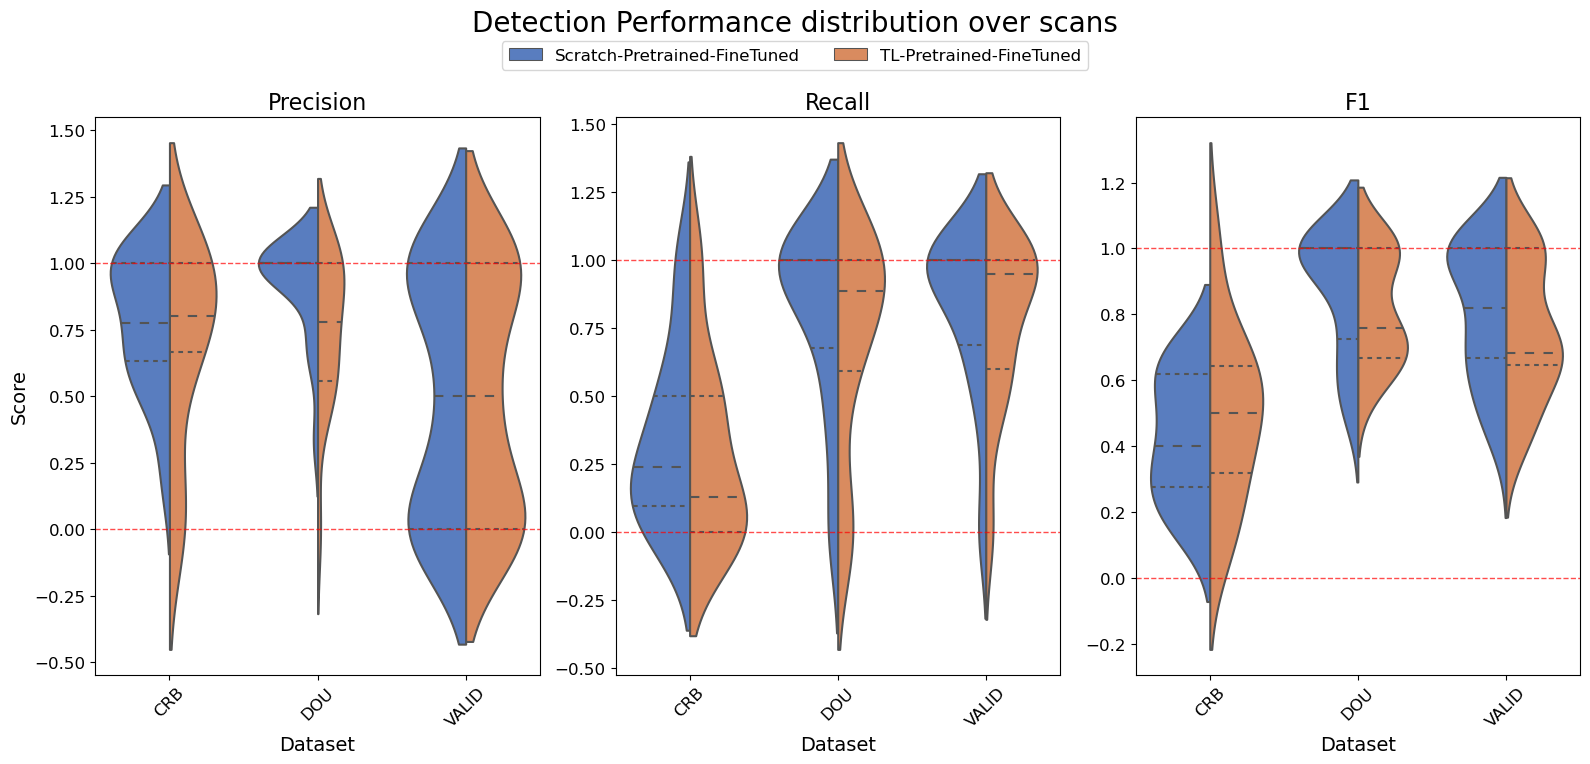

In [11]:
# Definitions
datasets = ["crb", "dou", "valid"]
models = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
criteria = ["valloss"]
metrics = ["Precision", "Recall", "F1"]

# Setup figure and axes
# fig, axs = plt.subplots(2, len(metrics), figsize=(18, 18))
fig, axs = plt.subplots(1, len(metrics), figsize=(16, 8))
fig.suptitle("Detection Performance distribution over scans", fontsize=20)

# Iterate over metrics to create a plot for each
for j, metric in enumerate(metrics):
    data_comb = pd.DataFrame()
    for model in models:
        for dataset in datasets:
            if (model, dataset, criteria[0]) in detection_details:
                detection_details_comb = detection_details[(model, dataset, criteria[0])]
                model_data = pd.DataFrame({
                    "Value": [s[metric] for s in detection_details_comb],
                    "Dataset": [dataset.upper()] * len(detection_details_comb),
                    "Model": [model] * len(detection_details_comb)
                })
                data_comb = pd.concat([data_comb, model_data], ignore_index=True)

    if not data_comb.empty:
        utils_plotting.create_violin_plot(
            ax=axs[j],
            data=data_comb.sort_values('Dataset'),
            column='Value',
            group_by='Dataset',
            title=f'{metric.capitalize()}',
            xlabel='Dataset',
            ylabel='Score' if j == 0 else "",
            hue = 'Model',
            split = True,
            rotation=45,
            fontsize_title=16,
            fontsize_labels=14,
            fontsize_ticks=12,
            palette="muted",
            cut=2,  
            showfliers=True,
            showmeans=False,  # Optionally display the means
            inner="quartile",  # Show quartiles within the violin
            y_lim=None,

        )
        # Drawing horizontal lines at y=0 and y=1
        axs[j].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)  # Line at y=0
        axs[j].axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.7)  # Line at y=1


        # utils_plotting.create_violin_plot(
        #     ax=axs[1, j],
        #     data=data_comb.sort_values('Dataset'),
        #     column='Value',
        #     group_by='Dataset',
        #     title=f'{metric.capitalize()}',
        #     xlabel='Dataset',
        #     ylabel='Score' if j == 0 else "",
        #     hue = 'Model',
        #     split = True,
        #     rotation=45,
        #     fontsize_title=16,
        #     fontsize_labels=14,
        #     fontsize_ticks=12,
        #     palette="muted",
        #     cut=0,  
        #     showfliers=True,
        #     showmeans=False,  # Optionally display the means
        #     inner="quartile",  # Show quartiles within the violin
        #     y_lim=(-0.1, 1.1),

        # )
        # Remove the legend from all except the last plot
        axs[j].get_legend().remove()


# Add a single unified legend for the whole figure
handles, labels = axs[j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(models), fontsize=12, bbox_to_anchor=(0.5, 0.95))

# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("../../data-misc/img/final_scores_dataset_model.png")
plt.show()


/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/evo1/jorge/anaconda3/envs/crbr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

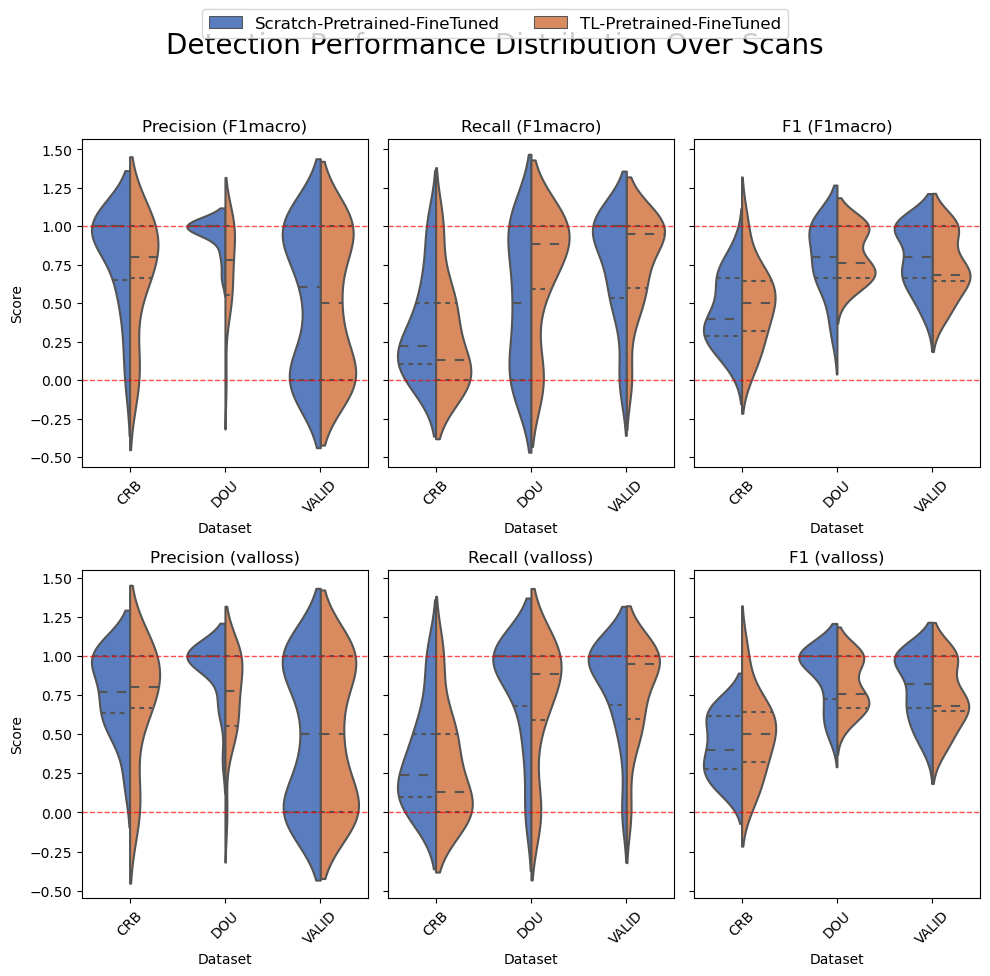

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming detection_details is a dictionary with keys (model, dataset, criteria)
# Example data structure needed for this script to work correctly

# Definitions
datasets = ["crb", "dou", "valid"]
models = ["Scratch-Pretrained-FineTuned", "TL-Pretrained-FineTuned"]
criteria = ["F1macro", "valloss"]
metrics = ["Precision", "Recall", "F1"]

# Setup figure and axes
fig, axs = plt.subplots(len(criteria), len(metrics), figsize=(10, 10), sharey='row')  # Adjusted to share y-axis by row
fig.suptitle("Detection Performance Distribution Over Scans", fontsize=20)


data_detection_all_df = pd.DataFrame()

# Iterate over each criterion and metric to create a plot for each combination
for i, crit in enumerate(criteria):
    for j, metric in enumerate(metrics):
        data_comb = pd.DataFrame()
        for model in models:
            for dataset in datasets:
                key = (model, dataset, crit)
                if key in detection_details:
                    detection_details_comb = detection_details[key]
                    model_data = pd.DataFrame({
                        "Criteria": [crit] * len(detection_details_comb),
                        "Metric": [metric]  * len(detection_details_comb),
                        "Value": [s[metric] for s in detection_details_comb],
                        "Dataset": [dataset.upper()] * len(detection_details_comb),
                        "Model": [model] * len(detection_details_comb)
                    })
                    data_comb = pd.concat([data_comb, model_data], ignore_index=True)
        data_detection_all_df = pd.concat([data_detection_all_df, data_comb], ignore_index=True)
        if not data_comb.empty:
            sns.violinplot(
                ax=axs[i, j],  # Adjusted axis indexing to handle rows and columns
                data=data_comb,
                x='Dataset',
                y='Value',
                hue='Model',
                split=True,
                inner="quartile",
                palette="muted"
            )
            axs[i, j].set_title(f'{metric.capitalize()} ({crit})')  # Show metric and criteria
            axs[i, j].set_xlabel('Dataset')
            axs[i, j].set_ylabel('Score' if j == 0 else "")
            axs[i, j].tick_params(axis="x", rotation=45)
            axs[i, j].tick_params(axis="y")
            axs[i, j].axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
            axs[i, j].axhline(1, color='red', linestyle='--', linewidth=1, alpha=0.7)
            
            # Remove the legend from all
            axs[i, j].get_legend().remove()

# Add a single unified legend for the whole figure
handles, labels = axs[-1, -1].get_legend_handles_labels()  # Grab handles and labels from the last plot
fig.legend(handles, labels, loc='upper center', ncol=len(models), fontsize=12, bbox_to_anchor=(0.5, 1.01))

# Adjust layout to accommodate the title and legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
